# Data Exploration - RNA 3D Folding Competition

This notebook explores the test sequences and creates a catalog for systematic analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Test Sequences

In [2]:
# Load data
test_seqs = pd.read_csv('../stanford-rna-3d-folding/test_sequences.csv')
valid_labels = pd.read_csv('../stanford-rna-3d-folding/validation_labels.csv')

print(f"Number of test sequences: {len(test_seqs)}")
print(f"Number of validation label rows: {len(valid_labels)}")

test_seqs.head()

Number of test sequences: 12
Number of validation label rows: 2515


,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."
3,R1117v2,UUGGGUUCCCUCACCCCAAUCAUAAAAAGG,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoni...,">8FZA_1|Chains A, B|PreQ1 Riboswitch (30-MER)|..."
4,R1126,GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUU...,2022-06-11,Traptamer\nSynthetic\nAdditional Information: ...,>8TVZ_1|Chain A[auth C]|RNA (363-MER)|syntheti...


## 2. Sequence Length Analysis

In [3]:
# Add length column
test_seqs['length'] = test_seqs['sequence'].str.len()

# Basic statistics
print("Sequence length distribution:")
print(test_seqs['length'].describe())

# Categorize by length
test_seqs['length_category'] = pd.cut(
    test_seqs['length'],
    bins=[0, 50, 100, 200, 400, 1000],
    labels=['Very Short (<50)', 'Short (50-100)', 'Medium (100-200)', 
            'Long (200-400)', 'Very Long (>400)']
)

print("\nLength categories:")
print(test_seqs['length_category'].value_counts())

Sequence length distribution:
count     12.000000
mean     209.583333
std      194.493963
min       30.000000
25%      105.750000
50%      129.500000
75%      269.250000
max      720.000000
Name: length, dtype: float64

Length categories:
length_category
Medium (100-200)    5
Long (200-400)      3
Short (50-100)      2
Very Short (<50)    1
Very Long (>400)    1
Name: count, dtype: int64


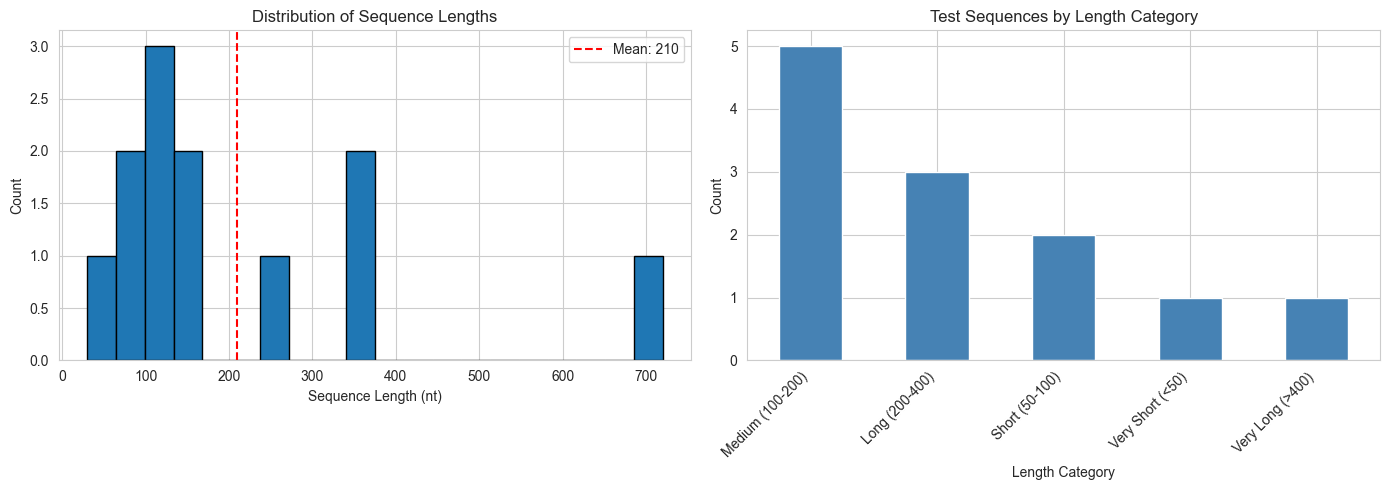

In [4]:
# Visualize length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(test_seqs['length'], bins=20, edgecolor='black')
axes[0].set_xlabel('Sequence Length (nt)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Sequence Lengths')
axes[0].axvline(test_seqs['length'].mean(), color='r', linestyle='--', label=f'Mean: {test_seqs["length"].mean():.0f}')
axes[0].legend()

# By category
test_seqs['length_category'].value_counts().plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_xlabel('Length Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Sequences by Length Category')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../figures/test_sequence_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. RNA Type Classification

In [5]:
def classify_rna_type(description):
    """Classify RNA based on description"""
    if pd.isna(description):
        return 'Unknown'
    
    desc_lower = description.lower()
    
    # Check for specific types
    if 'riboswitch' in desc_lower:
        return 'Riboswitch'
    elif 'ribozyme' in desc_lower:
        return 'Ribozyme'
    elif 'trna' in desc_lower or 't-rna' in desc_lower:
        return 'tRNA'
    elif 'rrna' in desc_lower or 'ribosom' in desc_lower:
        return 'rRNA'
    elif 'aptamer' in desc_lower:
        return 'Aptamer'
    elif 'loop' in desc_lower or 'hairpin' in desc_lower:
        return 'Loop/Hairpin'
    elif 'helix' in desc_lower or 'stem' in desc_lower:
        return 'Helix/Stem'
    elif 'viral' in desc_lower or 'virus' in desc_lower or 'cov' in desc_lower:
        return 'Viral RNA'
    else:
        return 'Other'

# Apply classification
test_seqs['rna_type'] = test_seqs['description'].apply(classify_rna_type)

print("RNA Type Distribution:")
print(test_seqs['rna_type'].value_counts())

RNA Type Distribution:
rna_type
Other           3
Ribozyme        2
Aptamer         2
Loop/Hairpin    2
tRNA            1
Riboswitch      1
Helix/Stem      1
Name: count, dtype: int64


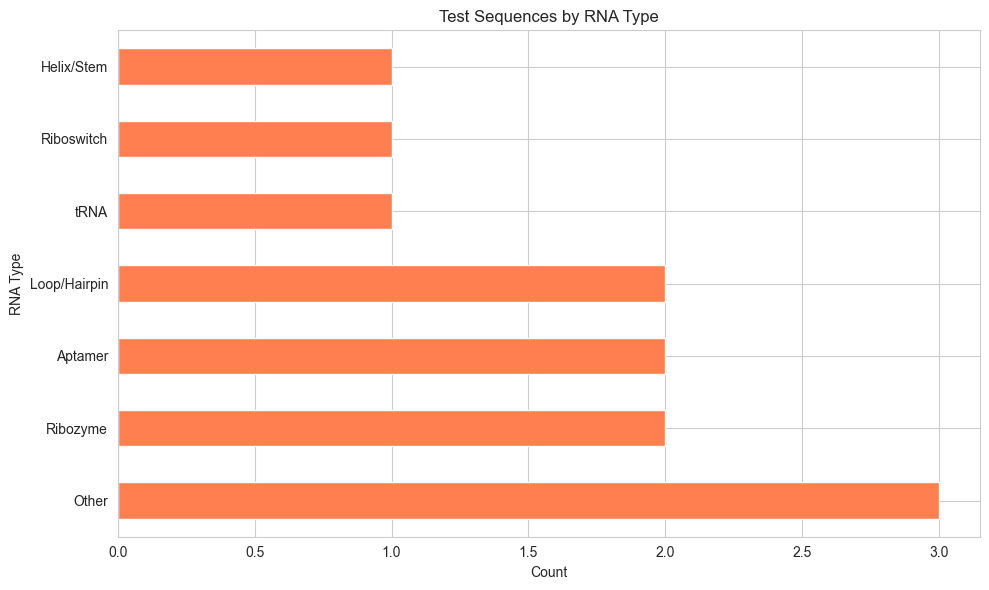

In [6]:
# Visualize RNA types
fig, ax = plt.subplots(figsize=(10, 6))
test_seqs['rna_type'].value_counts().plot(kind='barh', color='coral', ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('RNA Type')
ax.set_title('Test Sequences by RNA Type')
plt.tight_layout()
plt.savefig('../figures/test_sequence_types.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Sequence Composition Analysis

In [7]:
def calculate_composition(sequence):
    """Calculate nucleotide composition"""
    if pd.isna(sequence) or len(sequence) == 0:
        return {'A': 0, 'U': 0, 'G': 0, 'C': 0, 'GC': 0}
    
    length = len(sequence)
    return {
        'A': sequence.count('A') / length,
        'U': sequence.count('U') / length,
        'G': sequence.count('G') / length,
        'C': sequence.count('C') / length,
        'GC': (sequence.count('G') + sequence.count('C')) / length
    }

# Calculate composition for each sequence
compositions = test_seqs['sequence'].apply(calculate_composition)
composition_df = pd.DataFrame(compositions.tolist())

# Add to main dataframe
test_seqs = pd.concat([test_seqs, composition_df], axis=1)

print("Average nucleotide composition:")
print(composition_df[['A', 'U', 'G', 'C', 'GC']].mean())

Average nucleotide composition:
A     0.206205
U     0.219478
G     0.299257
C     0.275060
GC    0.574317
dtype: float64


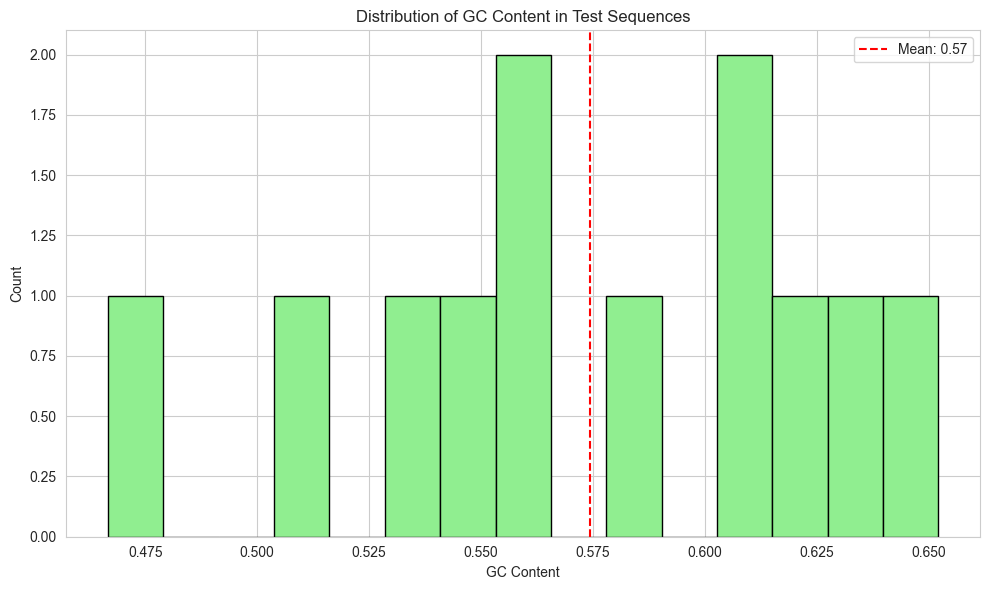

In [8]:
# Visualize GC content distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(test_seqs['GC'], bins=15, edgecolor='black', color='lightgreen')
ax.set_xlabel('GC Content')
ax.set_ylabel('Count')
ax.set_title('Distribution of GC Content in Test Sequences')
ax.axvline(test_seqs['GC'].mean(), color='r', linestyle='--', 
           label=f'Mean: {test_seqs["GC"].mean():.2f}')
ax.legend()
plt.tight_layout()
plt.savefig('../figures/gc_content_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Create Comprehensive Catalog

In [9]:
def extract_organism(description):
    """Extract organism from description"""
    if pd.isna(description):
        return 'Unknown'
    
    # Simple extraction based on common patterns
    if 'human' in description.lower() or 'homo sapiens' in description.lower():
        return 'Human'
    elif 'virus' in description.lower() or 'viral' in description.lower():
        return 'Virus'
    elif 'bacteria' in description.lower() or 'e. coli' in description.lower():
        return 'Bacteria'
    elif 'synthetic' in description.lower():
        return 'Synthetic'
    else:
        return 'Other'

# Create catalog
catalog = test_seqs[[
    'target_id', 'length', 'length_category', 'rna_type',
    'A', 'U', 'G', 'C', 'GC', 'temporal_cutoff', 'description'
]].copy()

catalog['organism'] = test_seqs['description'].apply(extract_organism)
catalog['has_ligand'] = test_seqs['description'].str.contains('ligand', case=False, na=False)

# Save catalog
catalog.to_csv('../results/test_sequences_catalog.csv', index=False)

print("Catalog created and saved!")
print(f"Shape: {catalog.shape}")
catalog.head()

Catalog created and saved!
Shape: (12, 13)


,target_id,length,length_category,rna_type,A,U,G,C,GC,temporal_cutoff,description,organism,has_ligand
0,R1107,69,Short (50-100),Ribozyme,0.173913,0.188406,0.289855,0.347826,0.637681,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,Human,False
1,R1108,69,Short (50-100),Ribozyme,0.159420,0.188406,0.304348,0.347826,0.652174,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,Other,False
2,R1116,157,Medium (100-200),tRNA,0.165605,0.210191,0.312102,0.312102,0.624204,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,Virus,False
3,R1117v2,30,Very Short (<50),Riboswitch,0.300000,0.233333,0.166667,0.300000,0.466667,2022-06-03,PreQ1 class I type III riboswitch\nK. pneumoni...,Bacteria,True
4,R1126,363,Long (200-400),Aptamer,0.201102,0.239669,0.303030,0.256198,0.559229,2022-06-11,Traptamer\nSynthetic\nAdditional Information: ...,Synthetic,False


## 6. Summary Statistics

In [10]:
print("="*60)
print("TEST SET SUMMARY")
print("="*60)
print(f"Total sequences: {len(test_seqs)}")
print(f"\nLength statistics:")
print(f"  Min: {test_seqs['length'].min()} nt")
print(f"  Max: {test_seqs['length'].max()} nt")
print(f"  Mean: {test_seqs['length'].mean():.1f} nt")
print(f"  Median: {test_seqs['length'].median():.1f} nt")

print(f"\nRNA Type breakdown:")
for rna_type, count in test_seqs['rna_type'].value_counts().items():
    print(f"  {rna_type}: {count} ({count/len(test_seqs)*100:.1f}%)")

print(f"\nComposition:")
print(f"  GC content: {test_seqs['GC'].mean():.2f} ± {test_seqs['GC'].std():.2f}")

print(f"\nSequences with ligands: {catalog['has_ligand'].sum()}")
print("="*60)

TEST SET SUMMARY
Total sequences: 12

Length statistics:
  Min: 30 nt
  Max: 720 nt
  Mean: 209.6 nt
  Median: 129.5 nt

RNA Type breakdown:
  Other: 3 (25.0%)
  Ribozyme: 2 (16.7%)
  Aptamer: 2 (16.7%)
  Loop/Hairpin: 2 (16.7%)
  tRNA: 1 (8.3%)
  Riboswitch: 1 (8.3%)
  Helix/Stem: 1 (8.3%)

Composition:
  GC content: 0.57 ± 0.06

Sequences with ligands: 2


## Next Steps

1. Process training data: `python ../scripts/process_training_data.py`
2. Extract TBM functions from winner's notebook
3. Run baseline benchmark